In [1]:
%load_ext autoreload
%autoreload 2

## imports and file settings

In [2]:
import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tools_edmz.atlas import Atlas
from tools_edmz.process_df import count_cells, group_counts, collapse_structures, filter_df, normalize_df

atlas = Atlas(json_version="clearmap")

In [3]:
FOLDER_DATA = "/Users/edmz/data/icm_data/bulk_corrected/"
FOLDER_FIGS = "/Users/edmz/figures/figs_20220927"

In [33]:
# set sample source files and corresponding names

base_folder = '/data/raid0/etienne/data'
map_path_to_sample_name = {
     f'{FOLDER_DATA}cells_200316-114.feather': 'Dp114',
     f'{FOLDER_DATA}cells_200316-104.feather': 'Dp104',
     f'{FOLDER_DATA}cells_200316-96.feather': 'Ct96',
     f'{FOLDER_DATA}cells_200316-105.feather': 'Dp105',
     f'{FOLDER_DATA}cells_200316-107.feather': 'Dp107',
     f'{FOLDER_DATA}cells_200316-95.feather': 'Ct95',
     f'{FOLDER_DATA}cells_200316-81.feather': 'Ct81',
     f'{FOLDER_DATA}cells_200316-100.feather': 'Ct100',
     f'{FOLDER_DATA}cells_200316-82.feather': 'Ct82',
}

sample_paths = list(map_path_to_sample_name.keys())
sample_names = list(map_path_to_sample_name.values())

path = sample_paths[0] #for debugging

In [34]:
#Set order used in the plots
sample_names_ordered = ['Ct82', 'Ct96', 'Ct95', 'Ct81', 'Ct100', 'Dp104', 'Dp105', 'Dp107', 'Dp114' ]

## Example 1: normalize by counts in all structure of interest in the right hemisphere 

### Settings for structures displayed

In [35]:
# Set structures of interest
structures_oi = [
    981, 201, 1047, 1070, 1038, 1062, # layers of SS1bf
    353, 337, 345, 369, 361, # somatosensories except SS1bf (329)
    378, 22, 541, 922, 895, # associative areas
    909, # entorhinal areas, which are in Retrohippocampal region (822) 
    985, 993, # motor areas
    184, 1057, 677, 247, 669, 31, 972, 44, 714, 95, 254, # other isocortical
]

### Settings for normalization

In [36]:
# Set structures for normalization. These structures will be the 100% of the counts (number, hemisphere, included/excluded)

norm_structures = [
    981, 201, 1047, 1070, 1038, 1062, # layers of SS1bf
    353, 337, 345, 369, 361, # somatosensories except SS1bf (329)
    378, 22, 541, 922, 895, # associative areas
    909, # entorhinal areas, which are in Retrohippocampal region (822) 
    985, 993, # motor areas
    184, 1057, 677, 247, 669, 31, 972, 44, 714, 95, 254, # other isocortical
]

In [37]:
# Set hemisphere
norm_hemispheres = ['RH'] # or ['LH'] or ['RH', 'LH']

# Set include/exclude
norm_exclude = False # True or False (False means will take as 100% the regions listed,True will take as 100% everything else)

### Computation

In [38]:
# transform cells.feather into cell_count dataframes
counts = [count_cells(path) for path in sample_paths]
# regroup all samples in one table ('id', 'hemisphere' and sample_names)
table = group_counts(counts, sample_names)

# get a map_collapse that maps every child of structures_oi to their parent in structures_oi
map_collapse = atlas.get_map_to_parent(structures_oi)

# collapse the count dataframe (first, areas not in structures_oi are kept)
collapsed_table = collapse_structures(table, map_collapse)
# keeps only the structures_oi (areas not in structures_oi are filtered out)
filtered_table = filter_df(collapsed_table, structures_oi)

# calculate the value of 100% (for normalization)
normalize_100 = filter_df(collapsed_table, norm_structures, norm_hemispheres, exclude=norm_exclude)
# keeps only the structures_oi
normalize_100 = filter_df(normalize_table, structures_oi)

In [39]:
# normalize filtered_table by df
normalized_table = normalize_df(filtered_table, normalize_100)

# finally, get the annotation
normalized_table = atlas.enrich_df(normalized_table).sort_values(by="id", key=lambda ids: ids.map(lambda id_: structures_oi.index(id_)))

#### Save
normalized_table.to_csv(FOLDER_FIGS + 'example_1.csv')

### Plot

In [47]:
def plot_heatmap(df, sample_names, cmap, use_cbar=True, use_ylabels=True):
    """
    Changed it for additional keywords
    """
    sns.heatmap(data=df[sample_names],
                square=True,
                cmap=cmap,
                cbar=use_cbar,
                yticklabels=df['acronym'],
                xticklabels=sample_names,
                #vmax=150,  ### Tweek that 
                vmin=0,     ### Tweek that 
                annot=True,
                fmt='.1f',
                annot_kws=dict(fontsize='small')
            )
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_tick_params(length=0)
    plt.gca().yaxis.set_tick_params(length=0)
    plt.gca().tick_params(axis='x', labelsize=8)
    plt.gca().tick_params(axis='y', labelsize=10)
    if use_ylabels is False:
        plt.gca().set_yticklabels([]);

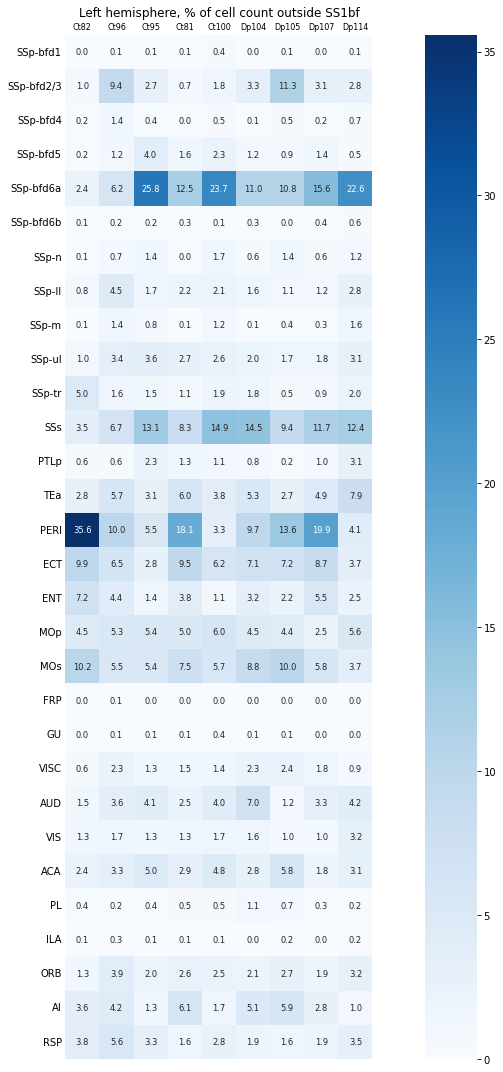

In [48]:
plt.figure(figsize=(15, 15))
plot_heatmap(normalized_table.query("hemisphere == 'RH'").head(50), sample_names_ordered,  "Blues",)
plt.title('Left hemisphere, % of cell count outside SS1bf')
plt.tight_layout()
plt.savefig(FOLDER_FIGS + 'toto.svg')

## Example 2: Raw counts

In [50]:
structures_oi = [378, 353, 329, 337, 345, 369, 361, # somatosensories
184, 500, 1057, 677, 247, 669, 31, 972, 44, 714, 95, 254, 22, 541, 922, 895, # other isocortical
313, 549, 1089, 477, 1097, 703, 1065, 698, 803, 1009] # other major structures

In [51]:
# transform cells.feather into cell_count dataframes
counts = [count_cells(path) for path in sample_paths]
# regroup all samples in one table ('id', 'hemisphere' and sample_names)
table = group_counts(counts, sample_names)

# get a map_collapse that maps every child of structures_oi to their parent in structures_oi
map_collapse = atlas.get_map_to_parent(structures_oi)

# collapse the count dataframe (first, areas not in structures_oi are kept)
collapsed_table = collapse_structures(table, map_collapse)
# keeps only the structures_oi (areas not in structures_oi are filtered out)
filtered_table = filter_df(collapsed_table, structures_oi)

In [52]:
# finally, get the annotation
final_table = atlas.enrich_df(filtered_table).sort_values(by="id", key=lambda ids: ids.map(lambda id_: structures_oi.index(id_)))

In [53]:
final_table.to_csv(FOLDER_FIGS + 'example_2.csv')

In [54]:
def plot_heatmap(df, sample_names, cmap, use_cbar=True, use_ylabels=True):
    """
    Changed it for additional keywords
    """
    sns.heatmap(data=df[sample_names],
                square=True,
                cmap=cmap,
                cbar=use_cbar,
                yticklabels=df['acronym'],
                xticklabels=sample_names,
                #vmax=150,  ### Tweek that 
                vmin=0,     ### Tweek that 
                #annot=True,
                #fmt='.1f',
                #annot_kws=dict(fontsize='small')
            )
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_tick_params(length=0)
    plt.gca().yaxis.set_tick_params(length=0)
    plt.gca().tick_params(axis='x', labelsize=8)
    plt.gca().tick_params(axis='y', labelsize=10)
    if use_ylabels is False:
        plt.gca().set_yticklabels([]);


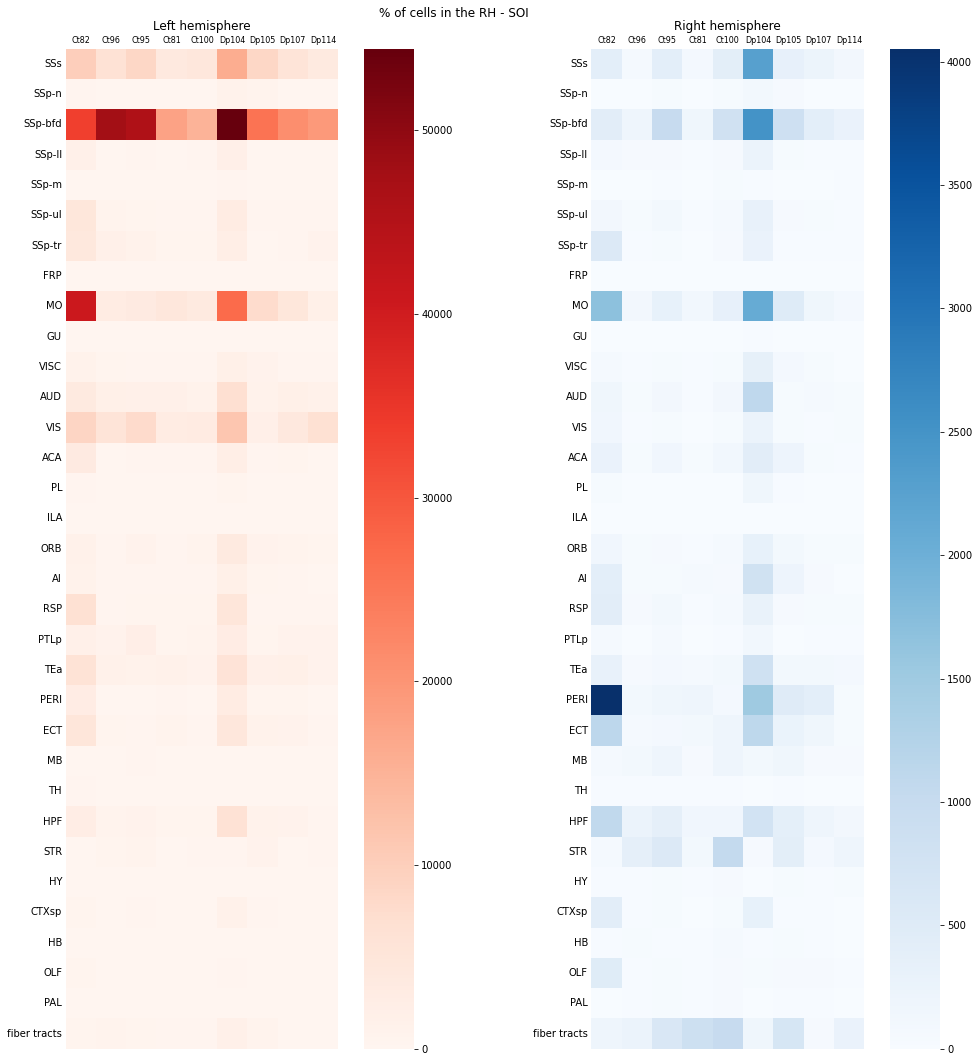

In [55]:
fig, axs = plt.subplots(1,2, figsize=(15, 15)) ### Tweek that
axs = axs.flat

plt.sca(next(axs))
plot_heatmap(final_table.query("hemisphere == 'LH'").head(50), sample_names_ordered, "Reds" )
plt.title('Left hemisphere')

plt.sca(next(axs))
plot_heatmap(final_table.query("hemisphere == 'RH'").head(50), sample_names_ordered,  "Blues", )
plt.title('Right hemisphere')

plt.suptitle('% of cells in the RH - SOI') #Title for the plot
plt.tight_layout()